In [1]:
"""
I am using a dataset of perovskite oxides to make a classification study based on their
stabilities, my target is the energy above convex hull values of these oxides and I 
have calculated various features that may be related with their stability.
"""

'\nI am using a dataset of perovskite oxides to make a classification study based on their\nstabilities, my target is the energy above convex hull values of these oxides and I \nhave calculated various features that may be related with their stability.\n'

In [2]:
import pandas as pd
import numpy as np

wolverton = pd.read_csv("wolverton_oxides.csv")

In [3]:
# Overview of the dataset

print(f"Dataframe has a shape of {wolverton.shape}")

# List categorical, numerical, and time-series features
categorical_features = wolverton.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = wolverton.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical Features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical Features ({len(numerical_features)}): {numerical_features}")

# Missingness statistics
missing_stats = (wolverton.isna().mean() * 100).sort_values(ascending=False)
print("\nMissingness Statistics (%) :")
print(missing_stats)


Dataframe has a shape of (4914, 16)

Categorical Features (5): ['formula', 'atom a', 'atom b', 'lowest distortion', 'mu_b']
Numerical Features (11): ['e_form', 'e_hull', 'vpa', 'gap pbe', 'a', 'b', 'c', 'alpha', 'beta', 'gamma', 'e_form oxygen']

Missingness Statistics (%) :
formula              0.0
atom a               0.0
atom b               0.0
lowest distortion    0.0
e_form               0.0
e_hull               0.0
mu_b                 0.0
vpa                  0.0
gap pbe              0.0
a                    0.0
b                    0.0
c                    0.0
alpha                0.0
beta                 0.0
gamma                0.0
e_form oxygen        0.0
dtype: float64


In [4]:
""""
I have calculated several features that may be related with stability based on
elemental compositions, namely: 
Weighted Atomic Mass 
Electronegativity Difference (A-B)
Electronegativity Ratio (A/B)
Ionization Energy Difference (A-B)
Mean Lattice Parameter
"""

import chemparse

# Loading PubChem
PubChemElements = pd.read_csv("PubChemElements_all.csv")

# Create property lookup dictionaries
atomic_mass_lookup = PubChemElements.set_index('Symbol')['AtomicMass'].to_dict()
electronegativity_lookup = PubChemElements.set_index('Symbol')['Electronegativity'].to_dict()
ionization_energy_lookup = PubChemElements.set_index('Symbol')['IonizationEnergy'].to_dict()

# Initialize lists to store calculated features
weighted_atomic_masses = []
electronegativity_differences = []
electronegativity_ratios = []
ionization_energy_differences = []
mean_lattice_parameters = []

# Iterate over Wolverton dataset rows
for _, row in wolverton.iterrows():
    try:
        # Parse the chemical formula
        formula_dict = chemparse.parse_formula(row['formula'])
        total_atoms = sum(formula_dict.values())

        # Calculate Weighted Atomic Mass
        weighted_atomic_mass = sum(
            atomic_mass_lookup[element] * count / total_atoms
            for element, count in formula_dict.items()
            if element in atomic_mass_lookup
        )
        weighted_atomic_masses.append(weighted_atomic_mass)

        # Calculate Electronegativity Difference and Ratio
        a_site_elements = [row['atom a']]
        b_site_elements = [row['atom b']]

        # Get electronegativities for A- and B-sites
        avg_a_electronegativity = np.mean(
            [electronegativity_lookup[element] for element in a_site_elements if element in electronegativity_lookup]
        )
        avg_b_electronegativity = np.mean(
            [electronegativity_lookup[element] for element in b_site_elements if element in electronegativity_lookup]
        )

        # Difference and Ratio
        electronegativity_difference = avg_a_electronegativity - avg_b_electronegativity
        electronegativity_ratio = avg_a_electronegativity / avg_b_electronegativity if avg_b_electronegativity != 0 else np.nan

        electronegativity_differences.append(electronegativity_difference)
        electronegativity_ratios.append(electronegativity_ratio)

        # Calculate Ionization Energy Difference
        avg_a_ionization_energy = np.mean(
            [ionization_energy_lookup[element] for element in a_site_elements if element in ionization_energy_lookup]
        )
        avg_b_ionization_energy = np.mean(
            [ionization_energy_lookup[element] for element in b_site_elements if element in ionization_energy_lookup]
        )

        ionization_energy_difference = avg_a_ionization_energy - avg_b_ionization_energy
        ionization_energy_differences.append(ionization_energy_difference)

        # Calculate Mean Lattice Parameters
        lattice_params = [row['a'], row['b'], row['c']]
        mean_lattice_param = np.mean(lattice_params)
        mean_lattice_parameters.append(mean_lattice_param)

    except Exception as e:
        print(f"Error processing formula {row['formula']}: {e}")
        weighted_atomic_masses.append(np.nan)
        electronegativity_differences.append(np.nan)
        electronegativity_ratios.append(np.nan)
        ionization_energy_differences.append(np.nan)
        mean_lattice_parameters.append(np.nan)

# Add calculated features to the Wolverton dataset
wolverton['Weighted Atomic Mass'] = weighted_atomic_masses
wolverton['Electronegativity Difference (A-B)'] = electronegativity_differences
wolverton['Electronegativity Ratio (A/B)'] = electronegativity_ratios
wolverton['Ionization Energy Difference (A-B)'] = ionization_energy_differences
wolverton['Mean Lattice Parameter'] = mean_lattice_parameters


In [5]:
# Applying one-hot encoding to my only categorical column.
encoded_data = pd.get_dummies(wolverton, columns=['lowest distortion'], prefix='cat')

In [6]:
# Preparing features for KNN imputation:
# Target is not included to prevent data leakage, categorical features also excluded.

features_for_imputation = encoded_data.drop(columns=['formula', 'atom a', 'atom b',
                                   'mu_b',
                                   'alpha', 'beta', 'gamma',
                                   'cat_cubic', 'cat_orthorhombic',
                                   'cat_rhombohedral', 'cat_tetragonal',
                                   'e_hull'])


In [7]:
"""
Applying standard scaling before KNN imputation for missing data in electronegativity
related features. Missingness is due to PubChem elemental dataset where there is no
data input for some elements, especially the ones with higher atomic weights.
"""

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# Standardizing the data
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features_for_imputation),
                               columns=features_for_imputation.columns)

# Applying KNN Imputation
imputer = KNNImputer(n_neighbors=5)
features_imputed_scaled = pd.DataFrame(imputer.fit_transform(features_scaled),
                                       columns=features_for_imputation.columns)

# Transforming back to original scale
numerical_features_imputed = pd.DataFrame(scaler.inverse_transform(features_imputed_scaled),
                                columns=features_for_imputation.columns)

In [8]:
# Select the specific columns from encoded_data
encoded_columns = encoded_data[['cat_cubic', 'cat_orthorhombic', 'cat_rhombohedral', 'cat_tetragonal']]

# Concatenate features_imputed with the selected columns
features_imputed = pd.concat([numerical_features_imputed, encoded_columns], axis=1)


In [9]:
# Indicating my target and creating the final data

target = wolverton['e_hull']

data = pd.concat([features_imputed, target], axis=1)

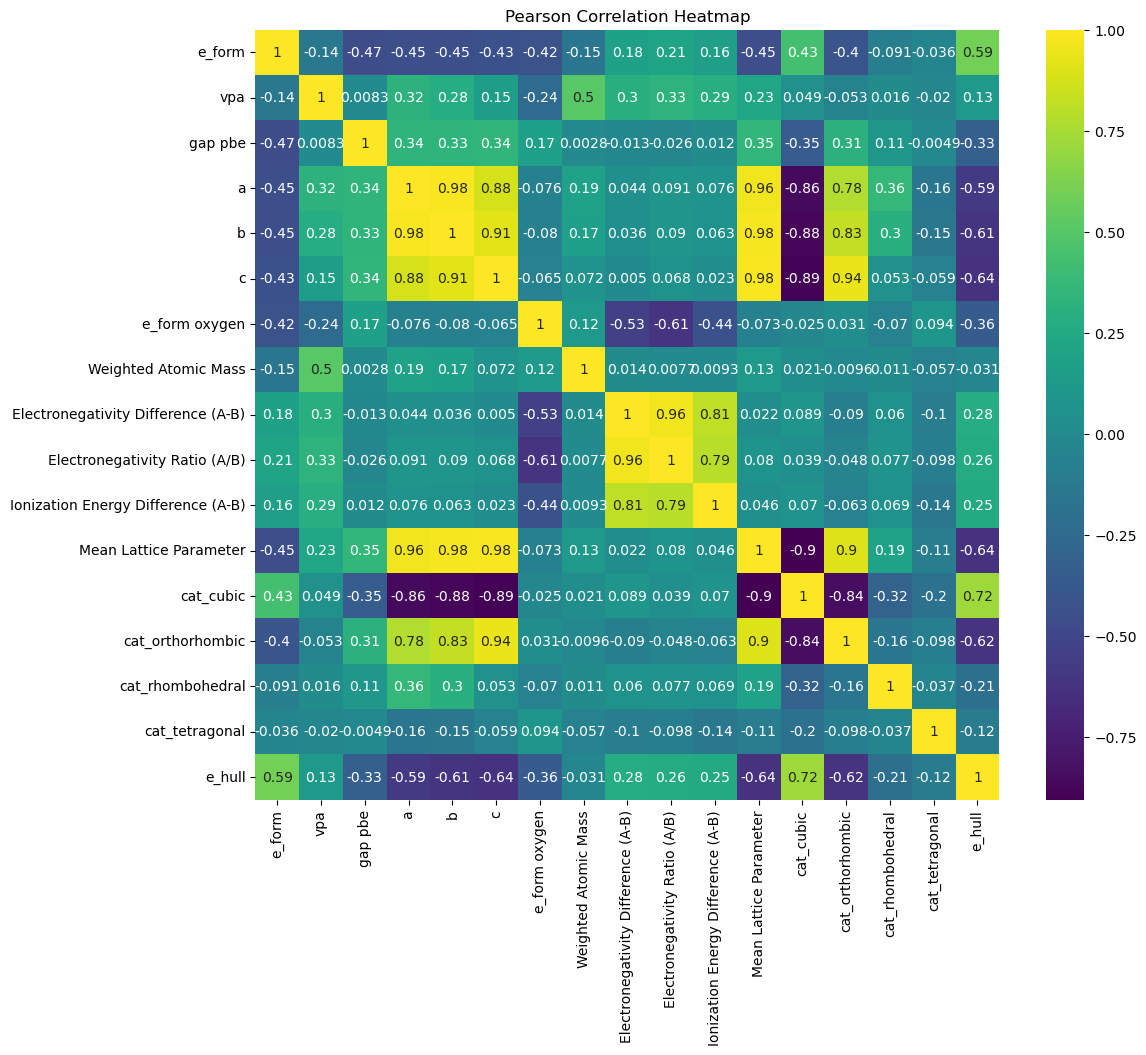

In [10]:
#Plotting a heatmap to check the correlations between numerical features.
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

pearson_corr = data.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(pearson_corr, annot=True, cmap='viridis')
plt.title('Pearson Correlation Heatmap')
plt.show()

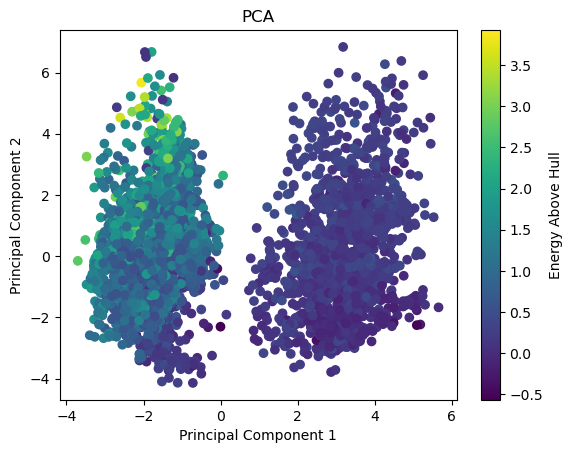

       e_form       vpa   gap pbe         a         b         c  \
PC1 -0.223717  0.083973  0.179202  0.391692  0.397550  0.391027   
PC2  0.174081  0.241621 -0.062887  0.052536  0.044239  0.008119   

     e_form oxygen  Weighted Atomic Mass  Electronegativity Difference (A-B)  \
PC1      -0.001748              0.057647                           -0.000820   
PC2      -0.392516              0.038469                            0.499601   

     Electronegativity Ratio (A/B)  Ionization Energy Difference (A-B)  \
PC1                       0.018607                            0.010055   
PC2                       0.511479                            0.461293   

     Mean Lattice Parameter  cat_cubic  cat_orthorhombic  cat_rhombohedral  \
PC1                0.403641  -0.374536          0.360204          0.093487   
PC2                0.027710   0.064867         -0.065452          0.058711   

     cat_tetragonal  
PC1       -0.030838  
PC2       -0.101588  


In [11]:
# Principal Component Analysis

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = StandardScaler()
features_standardized = scaler.fit_transform(features_imputed)

# Initially, number of principal components selected as 2 for visualisation purposes.

pca = PCA(n_components=2)
two_principal_components = pca.fit_transform(features_standardized)
explained_variance_ratio = pca.explained_variance_ratio_

plt.scatter(two_principal_components[:, 0], two_principal_components[:, 1], c=wolverton['e_hull'], cmap='viridis')
plt.colorbar(label='Energy Above Hull')
plt.title("PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

loadings = pca.components_

# Creating a DataFrame for better readability
loadings_df = pd.DataFrame(loadings, columns=features_imputed.columns, 
                           index=[f"PC{i+1}" for i in range(loadings.shape[0])])

print(loadings_df)

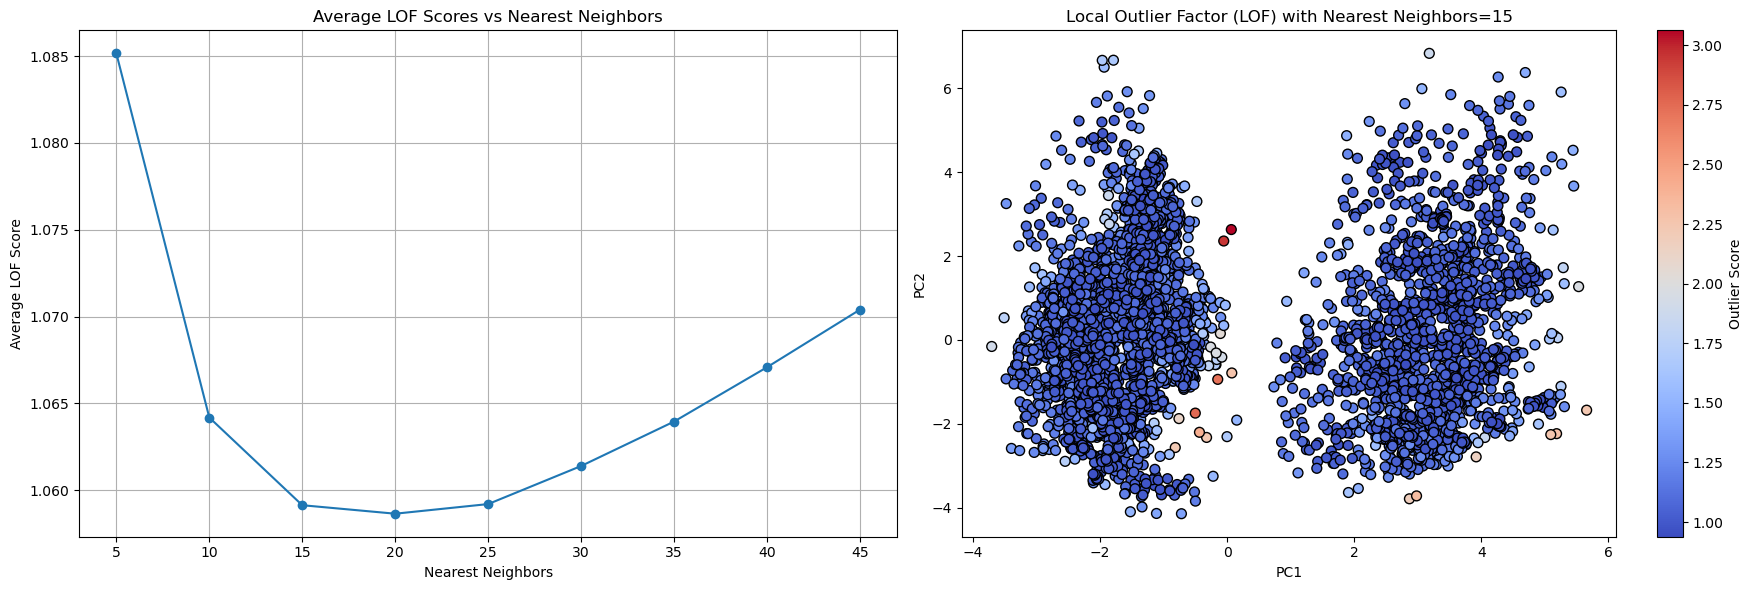

Number of outliers detected: 79
Proportion of outliers: 1.61%


In [12]:
"""
I did a multivariate outlier analysis using LoF and visualized it with first two
principal components. Outliers are perfectly distinguishable in 2D, meaning that
their electronic properties (mainly represented in PC2) are inconsistent with their
structural properties (mainly represented in PC1). They will be investigated further
while considering their stability; because if they are stable, it means they contain
valuable information for my study.
"""

from sklearn.neighbors import LocalOutlierFactor

# Testing different values of n_neighbors, trying values from 5 to 50 with a step of 5.

n_neighbors_range = range(5, 50, 5)
avg_lof_scores = []

for n in n_neighbors_range:
    lof = LocalOutlierFactor(n_neighbors=n)
    lof.fit(two_principal_components)
    avg_lof_scores.append(-lof.negative_outlier_factor_.mean())

# Choose an optimal n_neighbors based on the elbow point
optimal_n_neighbors = 15

# Fit LOF with the optimal n_neighbors
lof = LocalOutlierFactor(n_neighbors=optimal_n_neighbors)
y_pred = lof.fit_predict(two_principal_components)  # -1 indicates outliers, 1 indicates inliers
outlier_scores = -lof.negative_outlier_factor_


fig, axes = plt.subplots(1, 2, figsize=(18, 6))

#subplot1
axes[0].plot(n_neighbors_range, avg_lof_scores, marker='o', linestyle='-')
axes[0].set_title("Average LOF Scores vs Nearest Neighbors")
axes[0].set_xlabel("Nearest Neighbors")
axes[0].set_ylabel("Average LOF Score")
axes[0].grid(True)

#subplot2
scatter = axes[1].scatter(two_principal_components[:, 0], two_principal_components[:, 1], 
                          c=outlier_scores, cmap='coolwarm', edgecolor='k', s=50)
axes[1].set_title(f"Local Outlier Factor (LOF) with Nearest Neighbors={optimal_n_neighbors}")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
fig.colorbar(scatter, ax=axes[1], label='Outlier Score')  # Add colorbar to the second plot

plt.tight_layout()
plt.show()

outliers_in_data = features_imputed.copy()
outliers_in_data['Outlier'] = (y_pred == -1)  # True for outliers, False for inliers

# Checking the quantity and proportion of outliers
outlier_count = outliers_in_data['Outlier'].sum()
print(f"Number of outliers detected: {outlier_count}")
print(f"Proportion of outliers: {outlier_count / len(features_imputed) * 100:.2f}%")


In [13]:
"""
I applied Yeo-Johnson transformation to examine the behavior of outliers but it
really did not give a meaningful change. I believe it is due to the absence of
skewness in most of my features (except bandgap, inwhich outliers are crucial).
Since I can clearly observe the behavior of these outliers and since I will
probably use a tree-based model or a gradient boosting model (which are both robust
to outliers) for my classification study, I am leaving the outliers as they are.
"""

from sklearn.preprocessing import RobustScaler, PowerTransformer
import pandas as pd

features = features_imputed.copy()

# Robust Scaling (works well for data with outliers)
scaler_robust = RobustScaler()
features_robust_scaled = scaler_robust.fit_transform(features)  # Apply scaling

# Yeo-Johnson Transformation (handles both positive and negative values)
scaler_yeojohnson = PowerTransformer(method='yeo-johnson')
features_transformed = scaler_yeojohnson.fit_transform(features_robust_scaled)

features_transformed_df = pd.DataFrame(features_transformed, columns=features.columns)

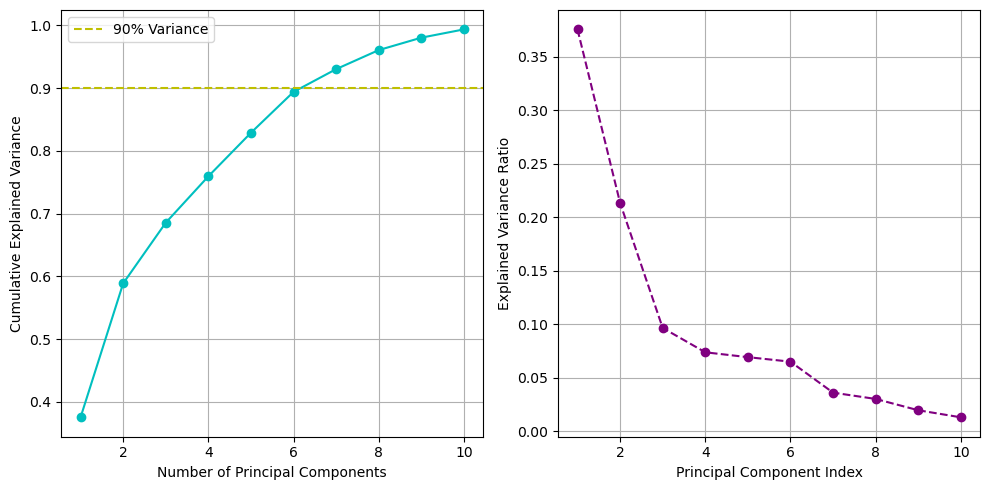

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Applying elbow method to determine the optimal number of principal components

pca = PCA(n_components=10)
pca_result = pca.fit_transform(features_standardized)

explained_variance_ratio = pca.explained_variance_ratio_

# Calculating cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting Cumulative Explained Variance
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='c')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.9, color='y', linestyle='--', label='90% Variance')
plt.legend()
plt.grid(True)

# Scree Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='purple')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
"""
Applying the final PCA for optimal number of principal components, 7.
Then, checking the loadings of principal components.
"""

from sklearn.decomposition import PCA

pca = PCA(n_components=7)
seven_principal_components = pca.fit_transform(features_standardized)

loadings = pca.components_

loadings_df = pd.DataFrame(loadings, columns=features_imputed.columns, index=[f"PC{i+1}" for i in range(loadings.shape[0])])

print(loadings_df)

       e_form       vpa   gap pbe         a         b         c  \
PC1 -0.223717  0.083973  0.179202  0.391692  0.397550  0.391027   
PC2  0.174081  0.241621 -0.062887  0.052536  0.044239  0.008119   
PC3 -0.272028  0.568584  0.061684  0.061294  0.022967 -0.099144   
PC4 -0.253527 -0.122113  0.406914  0.024788 -0.023858 -0.170258   
PC5  0.365859  0.052512 -0.489094  0.180695  0.144429 -0.043964   
PC6  0.093752  0.194434 -0.225904 -0.038979 -0.030436  0.056613   
PC7  0.157253  0.330931  0.581552  0.008200 -0.004387 -0.007090   

     e_form oxygen  Weighted Atomic Mass  Electronegativity Difference (A-B)  \
PC1      -0.001748              0.057647                           -0.000820   
PC2      -0.392516              0.038469                            0.499601   
PC3       0.220552              0.671827                           -0.037998   
PC4       0.144578             -0.165163                            0.105669   
PC5      -0.241953              0.107428                       

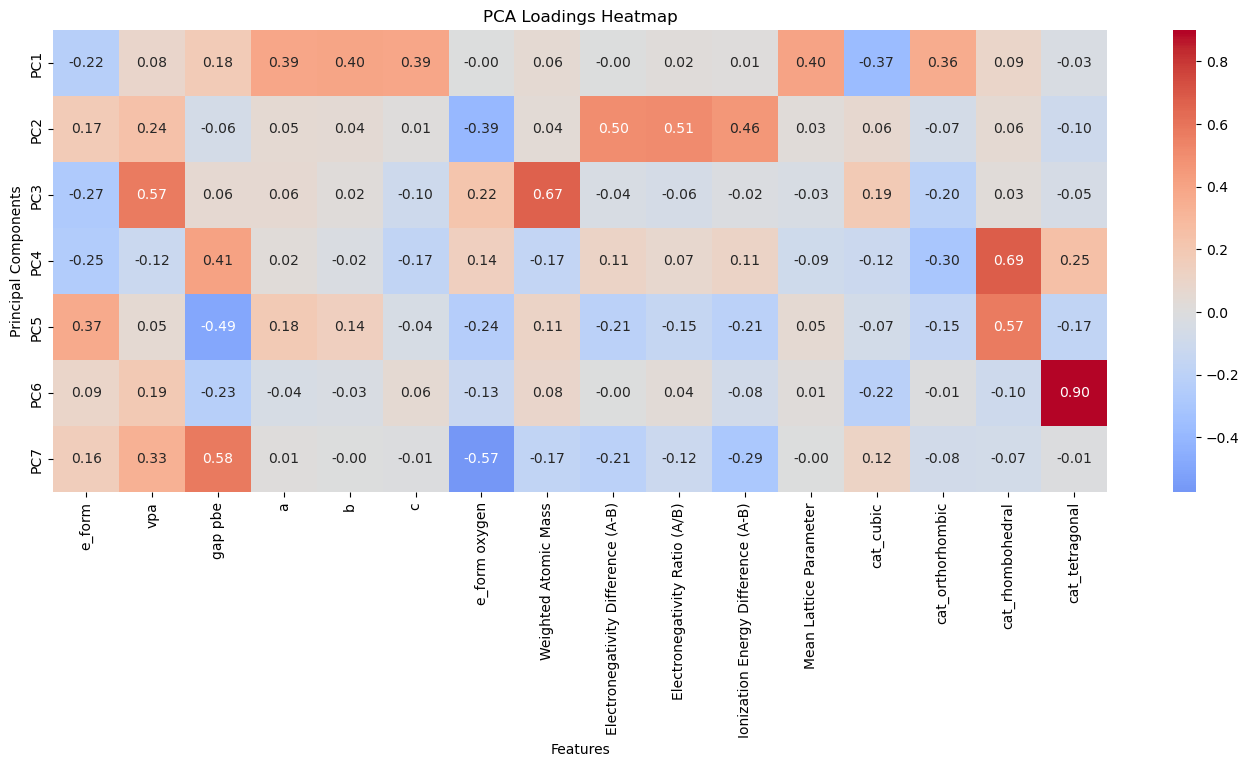

In [16]:
# Plotting a heatmap for better visualisation

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("PCA Loadings Heatmap")
plt.xlabel("Features")
plt.ylabel("Principal Components")
plt.show()


In [17]:
"""
It seems like PC1 heavily contains lattice properties (lattice parameters, volume per atom
and crystal structure). A significant portion of variance in terms of stability can be 
explained only with lattice properties.

PC2 on the other hand mainly contains electronic properties like electronegativity
differences and ionization energy differences.
"""

'\nIt seems like PC1 heavily contains lattice properties (lattice parameters, volume per atom\nand crystal structure). A significant portion of variance in terms of stability can be \nexplained only with lattice properties.\n\nPC2 on the other hand mainly contains electronic properties like electronegativity\ndifferences and ionization energy differences.\n'

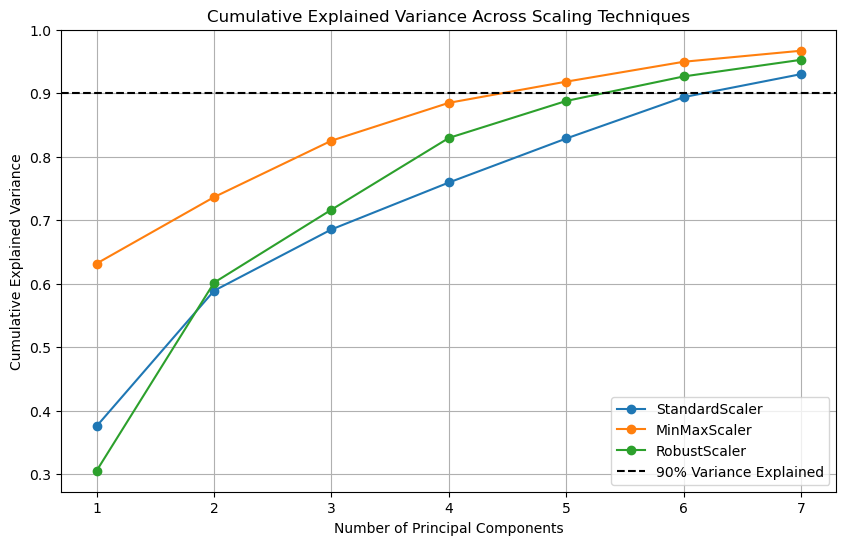

In [18]:
"""
ChatGPT helped me with comparing different scalers. I was really confused to see 
min-max scaling outperforming standard scaling. I believe the reason to that is my
most dominant features have very close to normal distributions.
"""

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Define Scalers
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

# Step 2: Apply Scaling and PCA
n_components = 7  # Number of principal components to keep
cumulative_variances = {}
reconstruction_errors = {}
pca_models = {}

for name, scaler in scalers.items():
    # Scale the data
    scaled_data = scaler.fit_transform(features_imputed)
    
    # Fit PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_data)
    
    # Store PCA model
    pca_models[name] = pca

    # Calculate cumulative explained variance
    cumulative_variances[name] = np.cumsum(pca.explained_variance_ratio_)

# Step 3: Plot Cumulative Explained Variance
plt.figure(figsize=(10, 6))
for name, cumulative_variance in cumulative_variances.items():
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label=name)
    
plt.axhline(y=0.9, color='k', linestyle='--', label='90% Variance Explained')
plt.title("Cumulative Explained Variance Across Scaling Techniques")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid(True)
plt.show()

/Users/umuttutal/miniconda3/envs/MyEnv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/umuttutal/miniconda3/envs/MyEnv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


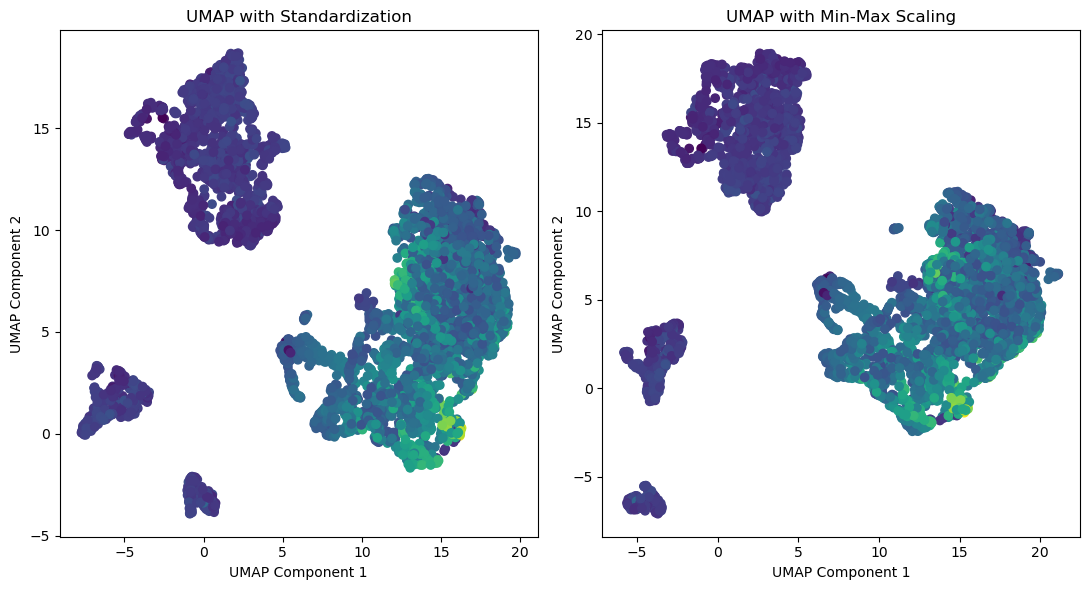

In [19]:
# Dimensionality reduction with UMAP

import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier

target = wolverton['e_hull'] 

# Applying Scaling
scaler_standard = StandardScaler()
scaler_min_max = MinMaxScaler()

features_standard = scaler_standard.fit_transform(features_imputed)
features_min_max = scaler_min_max.fit_transform(features_imputed)

# Applying UMAP on standarized and min-max scaled datasets
umap_standard = umap.UMAP(n_neighbors=25, min_dist=0.5, random_state=0)
umap_min_max = umap.UMAP(n_neighbors=25, min_dist=0.5, random_state=0)

umap_result_standard = umap_standard.fit_transform(features_standard)
umap_result_min_max = umap_min_max.fit_transform(features_min_max)

plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
plt.scatter(umap_result_standard[:, 0], umap_result_standard[:, 1], c=target, cmap='viridis')
plt.title("UMAP with Standardization")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

plt.subplot(1, 2, 2)
plt.scatter(umap_result_min_max[:, 0], umap_result_min_max[:, 1], c=target, cmap='viridis')
plt.title("UMAP with Min-Max Scaling")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

plt.tight_layout()
plt.show()

In [20]:
# Calculating Silhuoette scores with different scalings, results are very similar for UMAP.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans_standard = KMeans(n_clusters=5, random_state=42)
kmeans_min_max = KMeans(n_clusters=5, random_state=42)

labels_standard = kmeans_standard.fit_predict(umap_result_standard)
labels_min_max = kmeans_min_max.fit_predict(umap_result_min_max)

sil_score_standard = silhouette_score(umap_result_standard, labels_standard)
sil_score_min_max = silhouette_score(umap_result_min_max, labels_min_max)

print(f"Silhouette Score (Standardization): {sil_score_standard}")
print(f"Silhouette Score (Min-Max Scaling): {sil_score_min_max}")


Silhouette Score (Standardization): 0.47473496198654175
Silhouette Score (Min-Max Scaling): 0.45744043588638306


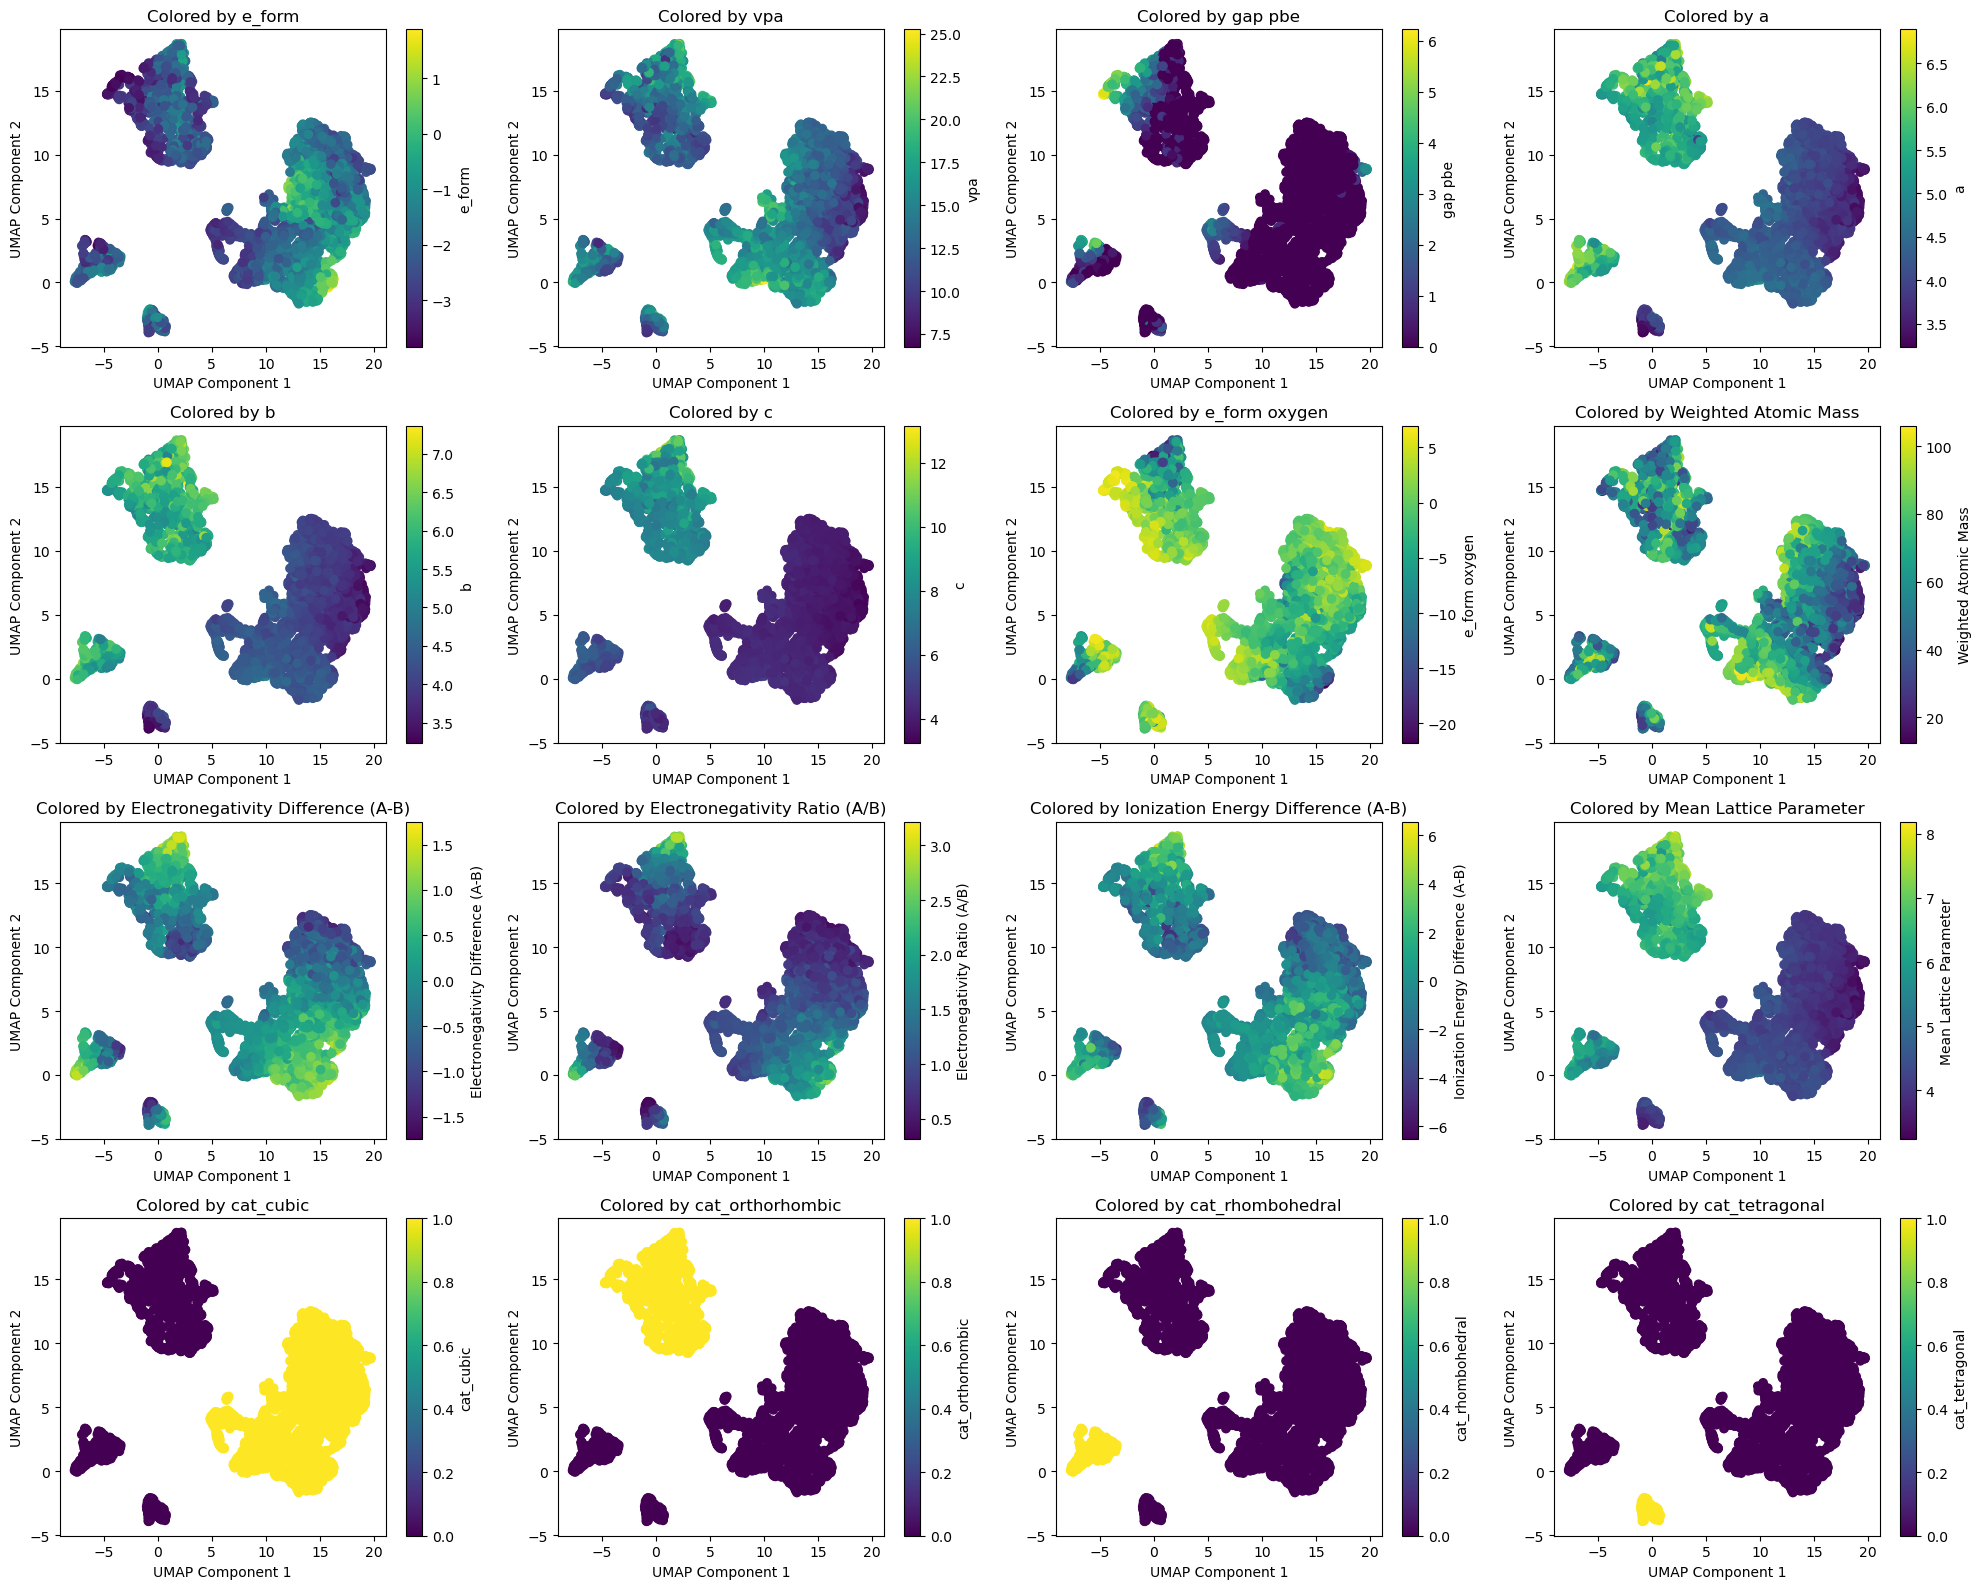

In [21]:
# Again with the help of ChatGPT I made scatter plots of umap components colored by each feature

import matplotlib.pyplot as plt

rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 16))  # Adjust size for readability
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot each feature in the grid
for i, feature in enumerate(features_imputed.columns): 
    sc = axes[i].scatter(umap_result_standard[:, 0], umap_result_standard[:, 1], 
                          c=features_imputed[feature], cmap='viridis')
    axes[i].set_title(f"Colored by {feature}")
    axes[i].set_xlabel("UMAP Component 1")
    axes[i].set_ylabel("UMAP Component 2")
    fig.colorbar(sc, ax=axes[i], label=feature)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


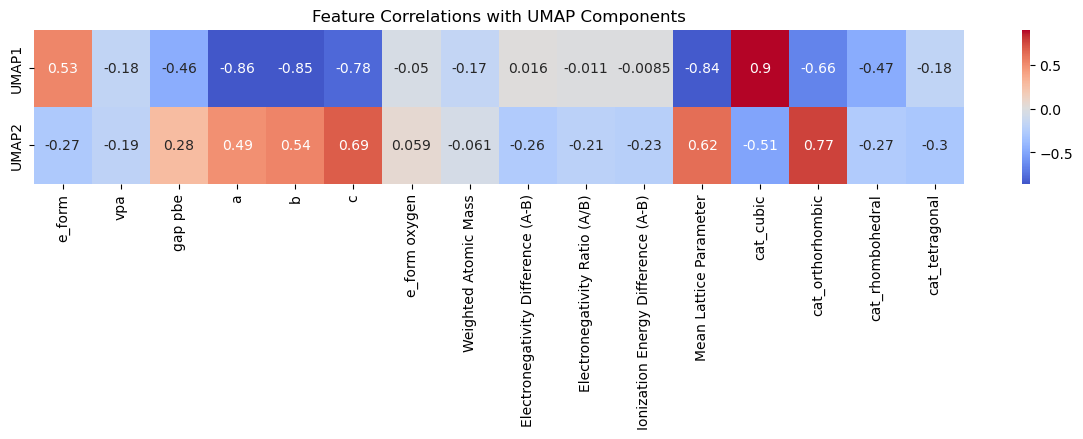

In [22]:
"""
Although we can not see what goes inside UMAP components it seemed reasonable to plot the
heatmap of features vs UMAP components to get an idea. It turns out they contain very
similar attributes with principal components.n_components
"""

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

umap_df = pd.DataFrame(umap_result_standard, columns=["UMAP1", "UMAP2"])

correlations = umap_df.join(features_imputed).corr()

correlation_umap1 = correlations.loc["UMAP1", features_imputed.columns] 
correlation_umap2 = correlations.loc["UMAP2", features_imputed.columns] 

plt.figure(figsize=(15, 2))
sns.heatmap(correlations.loc[["UMAP1", "UMAP2"], features_imputed.columns], annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlations with UMAP Components")
plt.show()




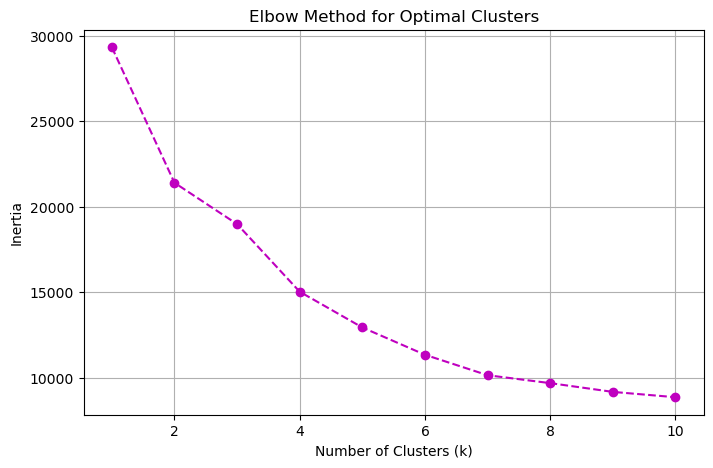

In [23]:
# Clustering
# Elbow method to determine the optimal number of clusters

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# range of cluster numbers to try
range_n_clusters = range(1, 11)

inertia = []
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o', linestyle='--', color='m')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

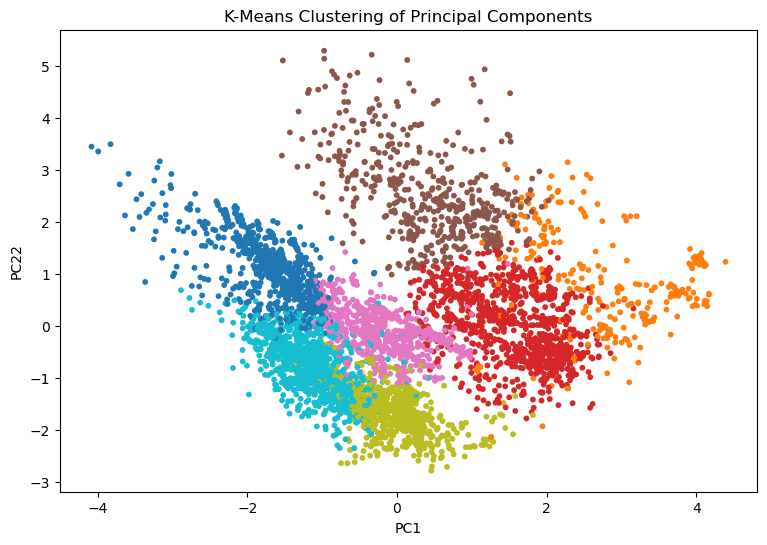

In [24]:
"""
I have decided to choose the elbow point at 7 clusters and applied the
K-means clustering accordingly. Results are consistent with PCA.
"""

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_result)

plt.figure(figsize=(9, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='tab10', s=10)
plt.title("K-Means Clustering of Principal Components")
plt.xlabel("PC1")
plt.ylabel("PC22")

plt.show()


In [25]:
# Hierarchical clustering

from scipy.cluster.hierarchy import linkage

linkage_matrix = linkage(umap_result_standard, method='ward')  # Use Ward's linkage


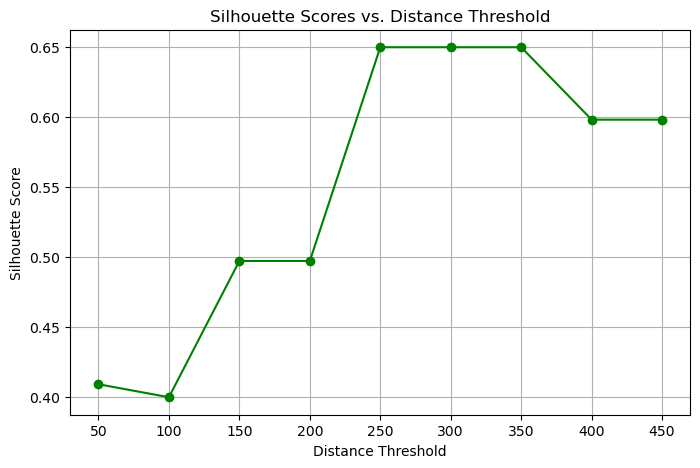

In [26]:
# I calculated Silhouette scores to decide for the distance threshold value.

from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt

thresholds = range(50, 500, 50)
silhouette_scores = []

for t in thresholds:
    clusters = fcluster(linkage_matrix, t=t, criterion='distance')  # Generate cluster labels
    if len(set(clusters)) > 1:  # Ensure there is more than one cluster
        sil_score = silhouette_score(umap_result_standard, clusters)
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(float('nan'))  # Append NaN if only one cluster is formed


plt.figure(figsize=(8, 5))
plt.plot(thresholds, silhouette_scores, marker='o', linestyle='-', color='g')
plt.title("Silhouette Scores vs. Distance Threshold")
plt.xlabel("Distance Threshold")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


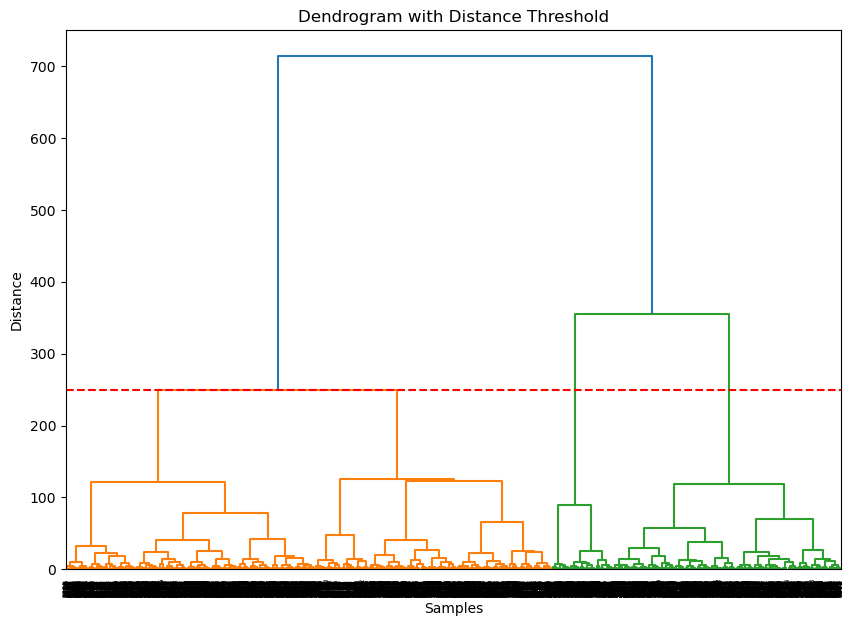

In [27]:
"""
It gave a peak between 250-350 so I have decided to set the threshold as 250. Any value
between 250-350 will yield 3 clusters as optimal value, according to the dendogram.
"""

from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)


plt.axhline(y=250, color='r', linestyle='--')


plt.title("Dendrogram with Distance Threshold")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


In [28]:
"""
After all, hierarchical clustering with highest silhouette score gave 3 natural
clusters for my data.
"""

threshold = 250
clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')

silhouette = silhouette_score(umap_result_standard, clusters)
print(f"Number of clusters: {len(set(clusters))}")
print(f"Silhouette Score: {silhouette}")


Number of clusters: 3
Silhouette Score: 0.6500462889671326


In [29]:
"""
Preparing for modelling using my principal components to avoid curse of dimensionality,
as well as the redundancy that may arise from the dominance of structural features.
I have chosen the cutoff value for e_hull as 0.04.
"""

# Create a new DataFrame with the 7 principal components
pca_df = pd.DataFrame(seven_principal_components, columns=[f"PC{i+1}" for i in range(7)])

# Add the 'is Stable' column
data['is Stable'] = data['e_hull'] <= 0.04  # True if e_hull <= 0.04, else False

# Combine the PCA components with the 'is Stable' column
data = pd.concat([pca_df, data[['is Stable']]], axis=1)

In [30]:
"""
Stratified Train-Test-Validation splitting with a ratio of 0.70:0.15:0.15
I have decided to use a validation set to use early stopping methods after
my first experience with modelling. At first, I noticed that any model that
I used is memorizing the data, so I am proceeding with early stopping (along
with regularization) to prevent overfitting.
"""

from sklearn.model_selection import train_test_split

X = data.drop(columns=['is Stable'])  # Drop only the 'is Stable' column to keep the PCA components
y = data['is Stable']  # Target variable remains the 'is Stable' column

# First, split into training and remaining (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Then, split the remaining into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Check the sizes of the splits
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 3439
Validation set size: 737
Test set size: 738


In [31]:
"""
Scaling the training set, then using the same scaler for test and validation sets.
"""

from sklearn.preprocessing import StandardScaler

# Step 1: Initialize the scaler
scaler = StandardScaler()

# Step 2: Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Step 3: Transform the validation data using the same scaler
X_val_scaled = scaler.transform(X_val)

# Step 4: Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)


                       Model  Accuracy  Precision    Recall  F1-Score  \
0        Logistic Regression  0.933604   0.766667  0.353846  0.484211   
1              Random Forest  0.959350   0.888889  0.615385  0.727273   
2  Support Vector Classifier  0.941734   0.866667  0.400000  0.547368   
3                    XGBoost  0.953930   0.792453  0.646154  0.711864   

    ROC-AUC  
0  0.945731  
1  0.962339  
2  0.913956  
3  0.967882  


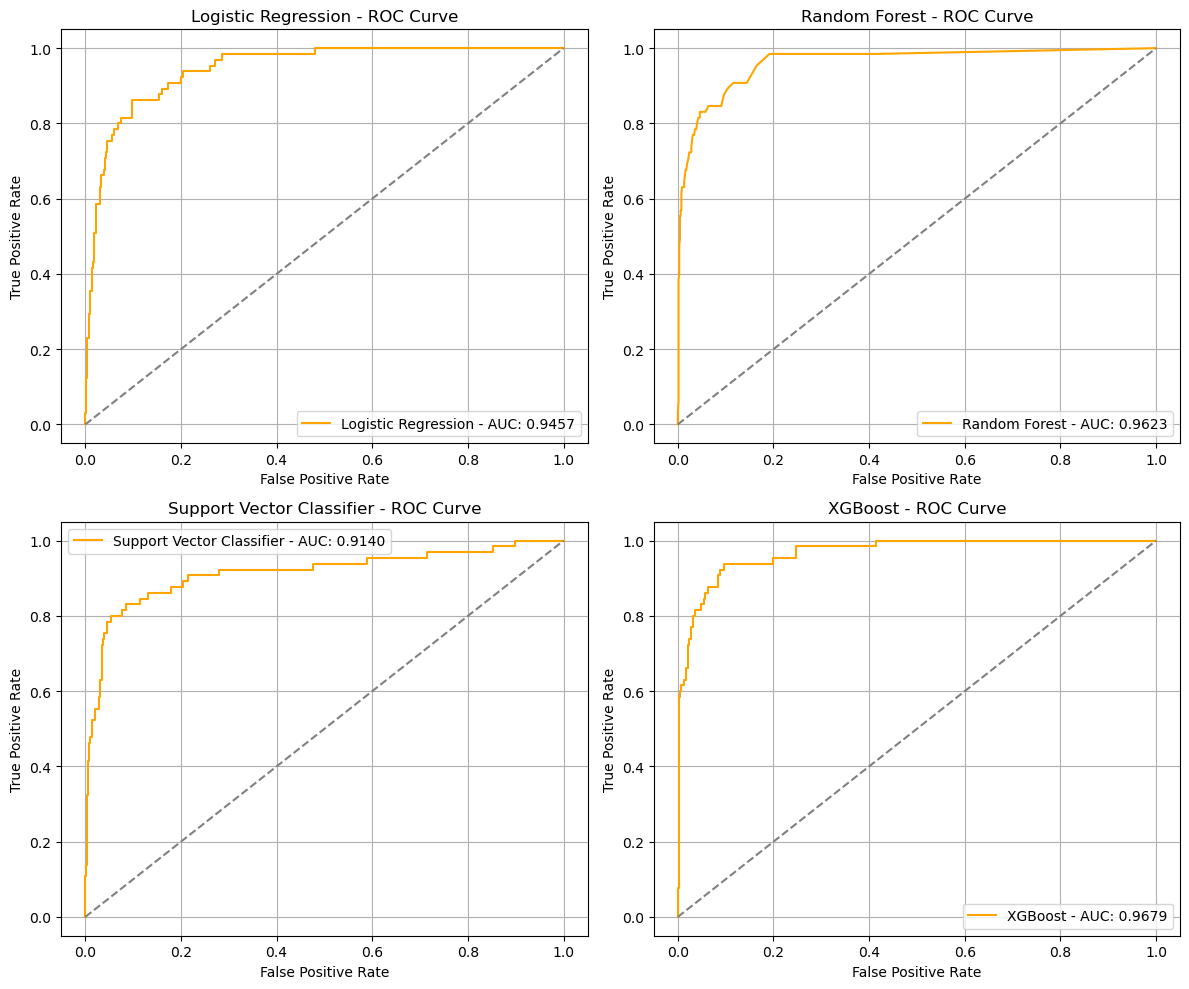

In [32]:
# Baseline Evaluation

"""
I decided to make a baseline evaluation first to decide which two models will suit better
for my dataset. This is just a rough analyze on the model performances without any hyperparameter
tuning or early stopping.
"""

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Classifier': SVC(random_state=42, probability=True),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

# Store results in a structured format
results_list = []

# Train and evaluate models
for name, model in models.items():
    # Fit the model
    model.fit(X_train_scaled, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate precision, recall, F1-score, and ROC-AUC
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])  # For binary classification
    
    # Append metrics to results list
    results_list.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results_list)

# Display the results
print(results_df)

# Plot ROC curves for each model (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, model_info in enumerate(models.items()):
    name, model = model_info
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    
    axes[i].plot(fpr, tpr, label=f'{name} - AUC: {auc:.4f}', color='orange')
    axes[i].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random model
    axes[i].set_title(f'{name} - ROC Curve')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].legend(loc='best')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

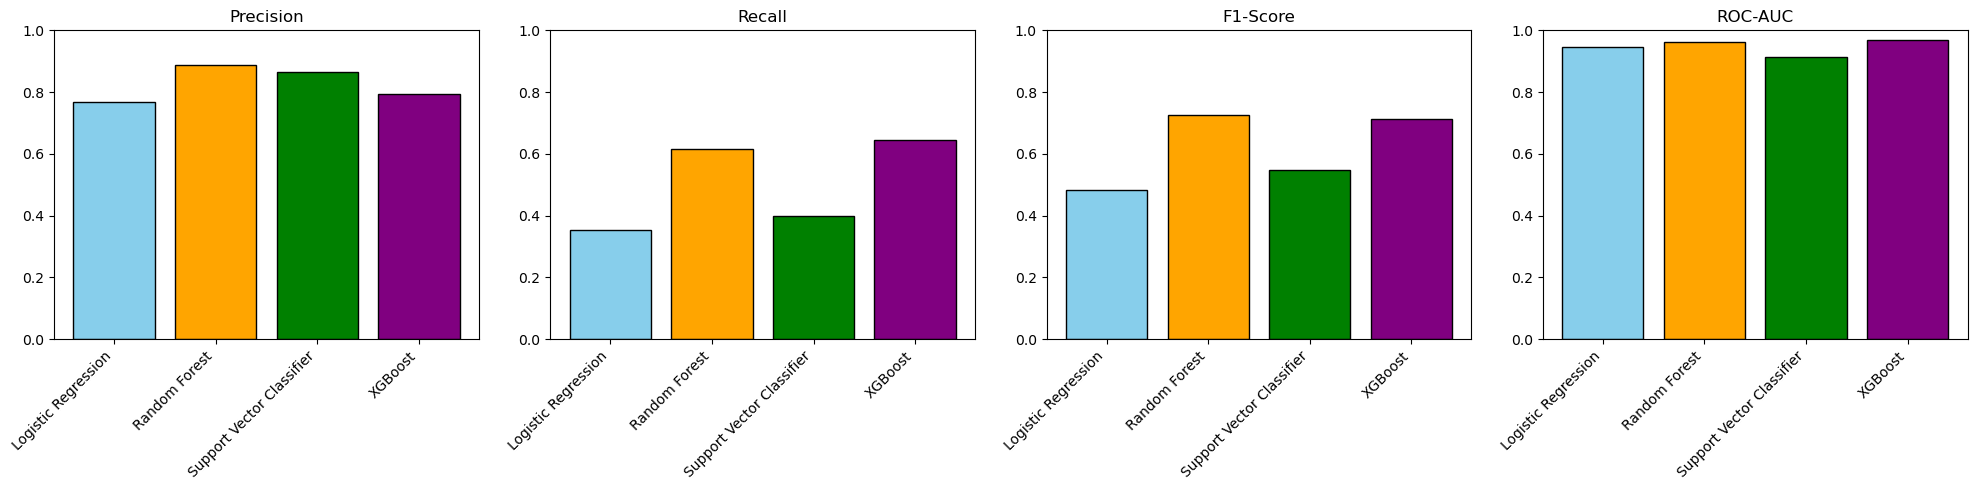

In [33]:
# Bar plots to better visualize model performances

metrics_to_plot = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['skyblue', 'orange', 'green', 'purple']

fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(20, 5))

for i, metric in enumerate(metrics_to_plot):
    axes[i].bar(
        results_df['Model'], 
        results_df[metric], 
        color=colors,
        edgecolor='black'
    )
    axes[i].set_title(metric)
    axes[i].set_ylim(0, 1)
    axes[i].set_xticks(range(len(results_df['Model'])))
    axes[i].set_xticklabels(results_df['Model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [34]:
# Hyperparameter Tuning

"""
I performed a grid search with 5-fold cross validation to obtain the optimal hyperparameters for
the two best performing models: Random Forest and XGBoost.
"""


from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [2, 4, 6, 8, 10],   # Depth of the tree
    'min_samples_split': [4, 7, 10],  # Minimum samples to split
    'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}

# Hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [5, 10, 15],         # Max depth of the tree
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'subsample': [0.8, 0.9, 1.0],     # Fraction of samples to train each tree
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features to use for each tree
    'gamma': [0.5],           # Regularization term (controls split)
    'min_child_weight': [5]    # Minimum sum of instance weight needed in a child
}

# Set up GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search_rf.fit(X_train_scaled, y_train)

# Set up GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb.XGBClassifier(random_state=42), xgb_param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search_xgb.fit(X_train_scaled, y_train)

# Best parameters and score for Random Forest
print("Best Random Forest Parameters:", grid_search_rf.best_params_)
print("Best Random Forest ROC-AUC:", grid_search_rf.best_score_)

# Best parameters and score for XGBoost
print("Best XGBoost Parameters:", grid_search_xgb.best_params_)
print("Best XGBoost ROC-AUC:", grid_search_xgb.best_score_)


Best Random Forest Parameters: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 7, 'n_estimators': 200}
Best Random Forest ROC-AUC: 0.9661675468544859
Best XGBoost Parameters: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost ROC-AUC: 0.9644916927139755


In [35]:
best_rf_params = grid_search_rf.best_params_
best_xgb_params = grid_search_xgb.best_params_

/Users/umuttutal/miniconda3/envs/MyEnv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


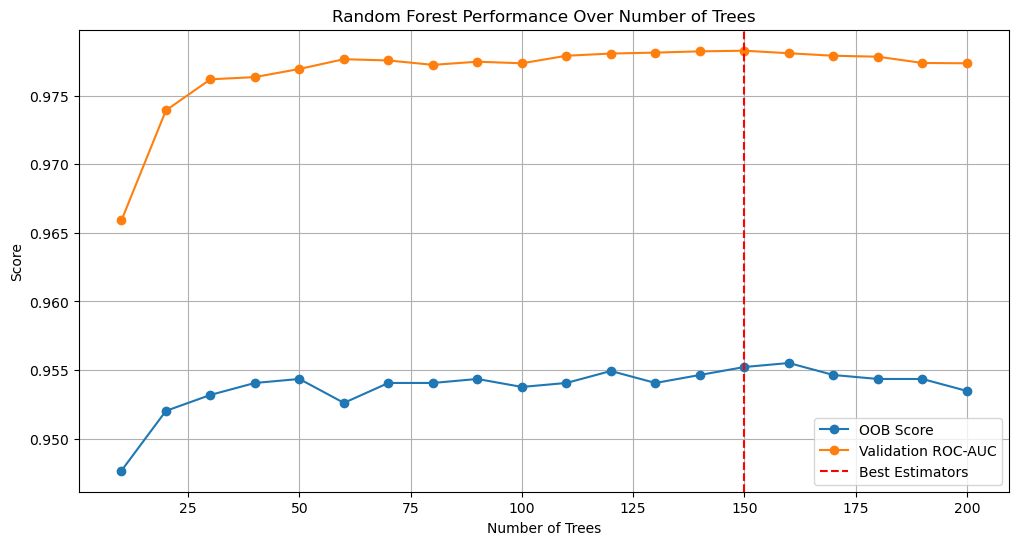

Best number of trees: 150
Best OOB Score: 0.9555
Best Validation ROC-AUC: 0.9783


In [36]:
"""
Early stopping algorithm to decide the optimal number of trees, remaining
hyperparameters are already obtained via grid search. This is an additional
measure to further prevent overfitting. The out-of-bag (OOB) score is a
metric used to evaluate the performance of bagging-based ensemble models
such as Random Forest. Actually it does not require a validation set since
it is calculated during training. I am going to use the validation set when
I am applying early stopping to XGBoost model.
"""

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Initialize Random Forest with warm_start=True to add trees incrementally
rf_model = RandomForestClassifier(
    n_estimators=20,  # Start with a small number of trees
    warm_start=True,  # Allows adding more trees later
    random_state=42,
    max_depth=8,  # Use parameters from grid search or best guess
    max_features="sqrt",
    min_samples_split=7,
    oob_score=True,  # Use Out-of-Bag samples for evaluation
)

# Initialize variables
n_estimators_list = []
oob_scores = []
validation_scores = []

# Incrementally train the model with more trees
for n_trees in range(10, 201, 10):  # Train with 10 to 200 trees, step by 10
    rf_model.set_params(n_estimators=n_trees)
    rf_model.fit(X_train_scaled, y_train)
    
    # Calculate OOB score
    oob_scores.append(rf_model.oob_score_)
    
    # Predict probabilities on the validation set
    y_val_pred_proba = rf_model.predict_proba(X_val_scaled)[:, 1]
    validation_scores.append(roc_auc_score(y_val, y_val_pred_proba))
    
    # Keep track of the number of trees
    n_estimators_list.append(n_trees)

# Plot OOB score and validation ROC-AUC over number of trees
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_list, oob_scores, label="OOB Score", marker="o")
plt.plot(n_estimators_list, validation_scores, label="Validation ROC-AUC", marker="o")
plt.axvline(x=n_estimators_list[validation_scores.index(max(validation_scores))],
            color='r', linestyle='--', label='Best Estimators')

plt.xlabel("Number of Trees")
plt.ylabel("Score")
plt.title("Random Forest Performance Over Number of Trees")
plt.legend()
plt.grid(True)
plt.show()

# Print best performance
best_trees = n_estimators_list[validation_scores.index(max(validation_scores))]
print(f"Best number of trees: {best_trees}")
print(f"Best OOB Score: {max(oob_scores):.4f}")
print(f"Best Validation ROC-AUC: {max(validation_scores):.4f}")


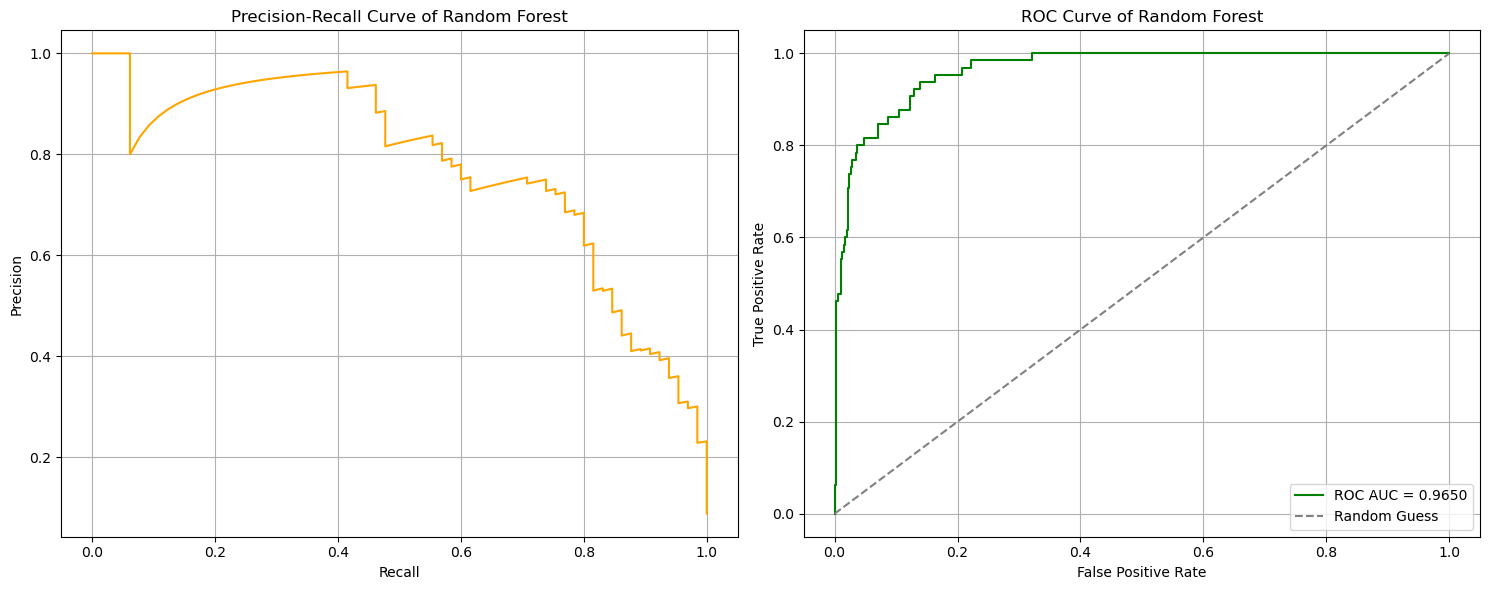

In [37]:
"""
Random Forest modelling with tuned hyperparameters and optimal number of trees.
"""

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Initialize the Random Forest model with the best parameters
rf_model = RandomForestClassifier(
    n_estimators=150,  # Best number of trees
    random_state=42,
    max_depth=8,
    max_features="sqrt",
    min_samples_split=7,
)

# Training the model
rf_model.fit(X_train_scaled, y_train)

# Predict probabilities for the test set
y_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# Predict probabilities for the training set (for OOB and ROC-AUC comparison)
train_probs = rf_model.predict_proba(X_train_scaled)[:, 1]

# Defining Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

# Defining ROC 
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Precision-Recall curve
axes[0].plot(recall, precision, color="orange")
axes[0].set_title("Precision-Recall Curve of Random Forest")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].grid()

# ROC curve
axes[1].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}', color="green")
axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
axes[1].set_title("ROC Curve of Random Forest")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")
axes[1].grid()

plt.tight_layout()
plt.show()

[0]	validation_0-auc:0.94713
[1]	validation_0-auc:0.96478
[2]	validation_0-auc:0.96646
[3]	validation_0-auc:0.96769
[4]	validation_0-auc:0.96889
[5]	validation_0-auc:0.96836
[6]	validation_0-auc:0.96603
[7]	validation_0-auc:0.96850
[8]	validation_0-auc:0.96818
[9]	validation_0-auc:0.96722
[10]	validation_0-auc:0.96758
[11]	validation_0-auc:0.96708
[12]	validation_0-auc:0.96639
[13]	validation_0-auc:0.97078
[14]	validation_0-auc:0.97087
[15]	validation_0-auc:0.97030
[16]	validation_0-auc:0.97040
[17]	validation_0-auc:0.96976
[18]	validation_0-auc:0.96909
[19]	validation_0-auc:0.96923
[20]	validation_0-auc:0.96909
[21]	validation_0-auc:0.97034
[22]	validation_0-auc:0.97073
[23]	validation_0-auc:0.97142
[24]	validation_0-auc:0.97139
[25]	validation_0-auc:0.97160
[26]	validation_0-auc:0.97138
[27]	validation_0-auc:0.97088
[28]	validation_0-auc:0.97079
[29]	validation_0-auc:0.97131
[30]	validation_0-auc:0.97145
[31]	validation_0-auc:0.97223
[32]	validation_0-auc:0.97289
[33]	validation_0-au

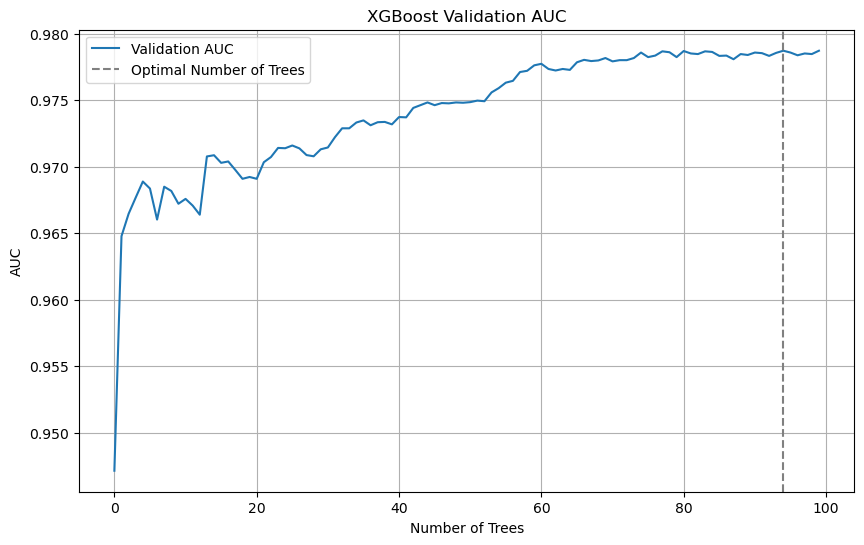

In [38]:
"""
A different early stopping method is used for XGBoost model with using 
the validation set. I also obtained the hyperparameters for XGBoost with
grid search and now I am trying to find the optimal number of trees. This
is a more robust method which directly calculates the area-under-curve
while displaying the progress.
"""

import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Best parameters from GridSearchCV
best_xgb_params = {
    'colsample_bytree': 0.9,
    'gamma': 0.5,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 5,
    'n_estimators': 100,
    'subsample': 0.9,
    'early_stopping_rounds': 20,  # Pass early stopping here
    'eval_metric': 'auc'         # Specify the evaluation metric
}

# Initialize the XGBoost model with early stopping
xgb_model = xgb.XGBClassifier(
    random_state=42,
    **best_xgb_params
)

# Train the model with early stopping
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=True  # Display progress
)

# Evaluate the model on the test set
y_test_pred = xgb_model.predict(X_test_scaled)
y_test_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print("XGBoost Model Evaluation on Test Set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"ROC-AUC: {test_roc_auc:.4f}")

# Plot training and validation metrics
results = xgb_model.evals_result()

plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['auc'], label="Validation AUC")
plt.axvline(x=xgb_model.best_iteration, color="gray", linestyle="--", label="Optimal Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("AUC")
plt.title("XGBoost Validation AUC")
plt.legend()
plt.grid()
plt.show()


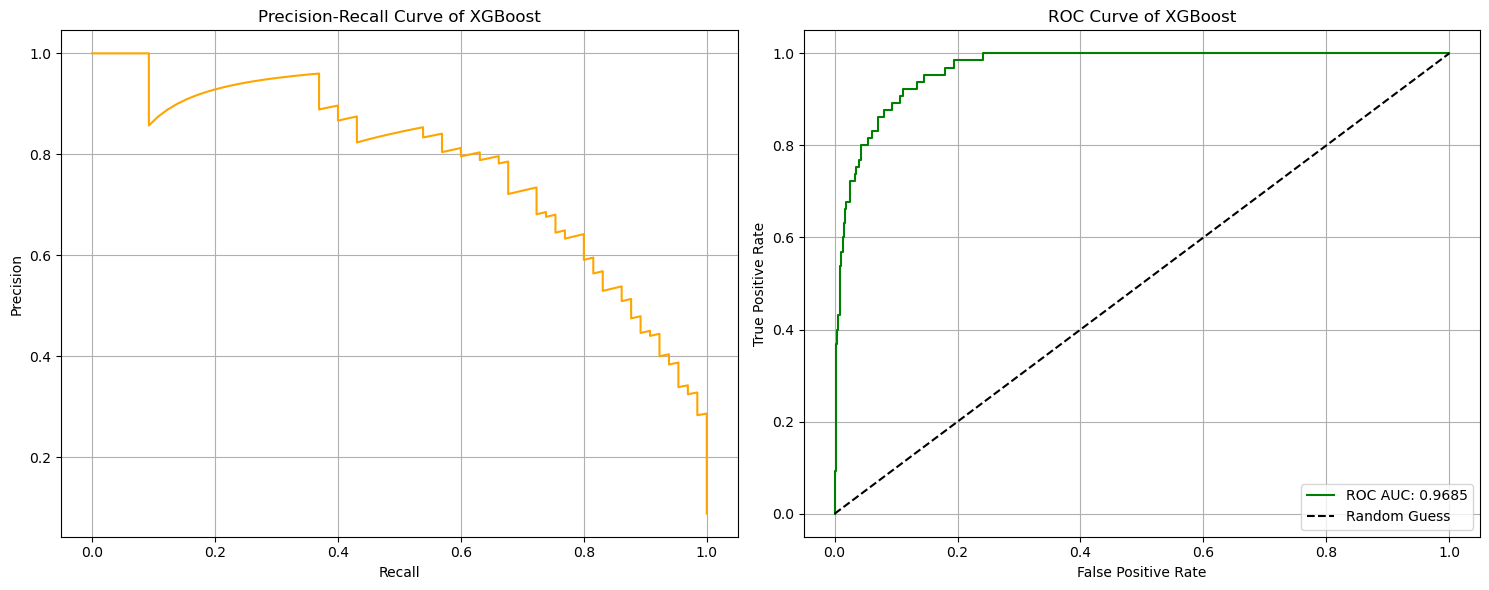

In [39]:
"""
XGBoost modelling with tuned hyperparameters and optimal number of trees.
"""

from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Update the best_xgb_params with the optimal number of trees
best_xgb_params['n_estimators'] = xgb_model.best_iteration + 1
best_xgb_params.pop('early_stopping_rounds', None)  # Remove early stopping
best_xgb_params.pop('eval_metric', None)  # Remove eval_metric

# Train the XGBoost model with the updated number of trees
final_xgb_model = xgb.XGBClassifier(
    random_state=42,
    **best_xgb_params
)

final_xgb_model.fit(X_train_scaled, y_train)

# Predictions for evaluation
y_test_pred = final_xgb_model.predict(X_test_scaled)
y_test_pred_proba = final_xgb_model.predict_proba(X_test_scaled)[:, 1]

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
pr_auc = auc(recall, precision)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot Precision-Recall and ROC curves side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Precision-Recall curve
axes[0].plot(recall, precision, color="orange")
axes[0].set_title("Precision-Recall Curve of XGBoost")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].grid(True)

# ROC curve
axes[1].plot(fpr, tpr, label=f"ROC AUC: {roc_auc:.4f}", color="green")
axes[1].plot([0, 1], [0, 1], "k--", label="Random Guess")
axes[1].set_title("ROC Curve of XGBoost")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

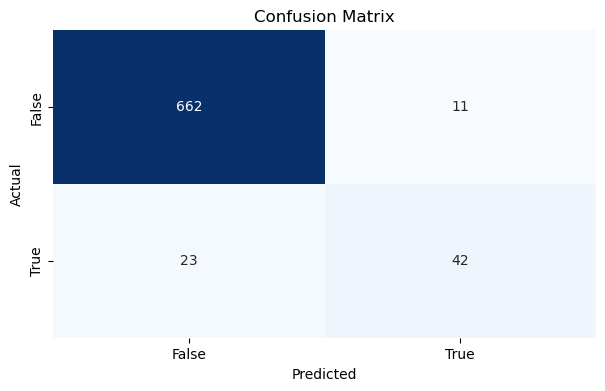

In [40]:
# Confusion Matrix of XGBoost

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plotting confusion matrix as heatmap
plt.figure(figsize=(7, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'], cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


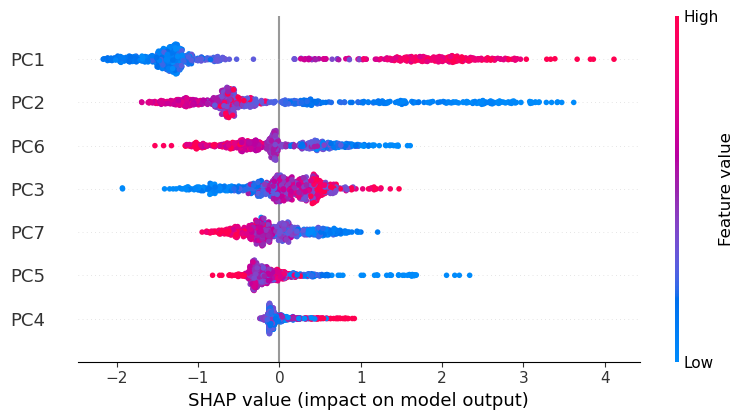

In [41]:
"""
I made a Shapley analysis with my principal components, although not directly,
it enables me to assess feature importances if examined together with the loadings.
"""

import shap
import pandas as pd

# Create a SHAP explainer
explainer = shap.Explainer(final_xgb_model, X_train_scaled)  # Use your trained model and training data

# Compute SHAP values for the test set
shap_values = explainer(X_test_scaled)

# Extract SHAP values as a matrix
shap_values_matrix = shap_values.values  # This gives the SHAP values as a NumPy array

# Convert SHAP values to a DataFrame for the principal components
shap_values_PC = pd.DataFrame(
    shap_values_matrix,
    columns=[f"PC{i+1}" for i in range(shap_values_matrix.shape[1])]
)

# Visualize summary plot for principal components
shap.summary_plot(shap_values, X_test_scaled, feature_names=[f"PC{i+1}" for i in range(X_train_scaled.shape[1])])


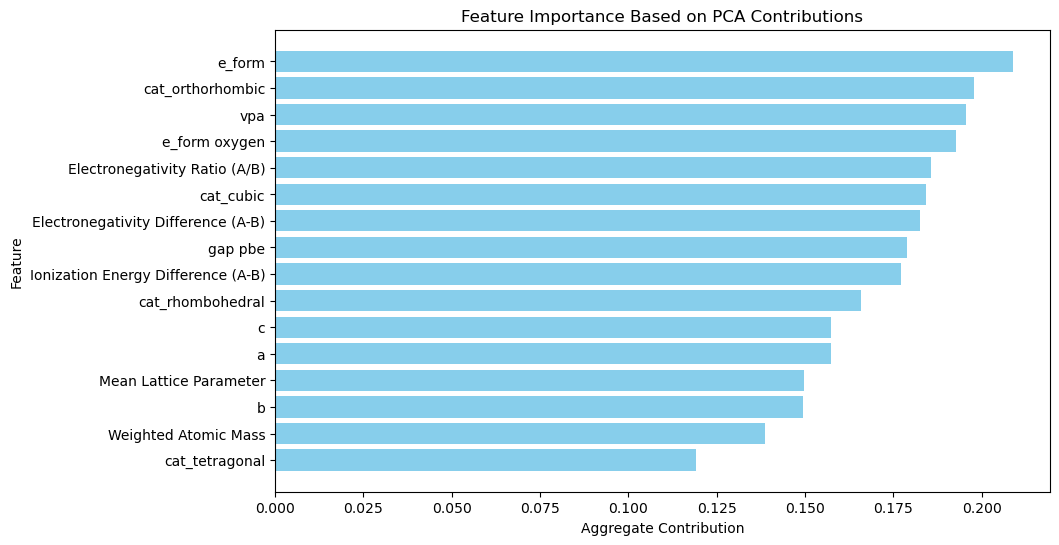

In [42]:
"""
With this plot, I tried to demonstrate the contribution of original features 
to the overall variance explained by the principal components. By this way,
it gives me an idea about the aggregate importances of each original feature.
"""

# Explained variance of each PC
explained_variance = pca.explained_variance_ratio_  # Shape: (n_PCs)

loadings_corrected = loadings.T if loadings.shape[0] == len(explained_variance) else loadings

# Compute contributions of each feature
feature_importance = np.abs(loadings_corrected) @ explained_variance  # Shape: (n_original_features)

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "Feature": features_imputed.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Aggregate Contribution")
plt.ylabel("Feature")
plt.title("Feature Importance Based on PCA Contributions")
plt.gca().invert_yaxis()
plt.show()


In [43]:
"""
Thank you so much, Hocam, for this insightful course. 
I have learned a lot, and it was a joy to do so. :)
"""

'\nThank you so much, Hocam, for this insightful course. \nI have learned a lot, and it was a joy to do so. :)\n'